In [1]:
import numpy as np
data = np.load('./rmd17.npz')

In [2]:
print(data.files)

['nuclear_charges', 'coords']


In [3]:
test_data_charges = data['nuclear_charges']
test_data_coords = data['coords']

## 1.分析测试集各个分子的原子类型分布与训练集的区别
通过对比可以发现，测试集的`rmd17.npz`数据集是由train中10种不同分子、每种1000个构象组成的

因此可以将`rmd17.npz`按照训练集的划分方法分割成对应的10个子数据集

In [4]:
diff_map = {}
last_idx ={}
for i, charge in enumerate(test_data_charges):
    atom_type = charge[charge != 0]
    key = str(atom_type)
    if key in diff_map:
        diff_map[key] += 1
    else:
        diff_map[key] = 1
    last_idx[key] = i

for k, v in diff_map.items():
    print(k, v)
print('============================')
for k, v in last_idx.items():
    print(k, v)

[6 6 6 6 6 6 6 8 8 8 6 6 8 1 1 1 1 1 1 1 1] 1000
[7 7 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1] 1000
[6 6 6 6 6 6 1 1 1 1 1 1] 1000
[6 6 8 1 1 1 1 1 1] 1000
[6 6 6 8 8 1 1 1 1] 1000
[6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1] 1000
[6 6 8 7 6 6 6 6 8 6 6 1 1 1 1 1 1 1 1 1] 1000
[6 6 6 8 6 6 6 6 8 8 1 1 1 1 1 1] 1000
[6 6 6 6 6 6 6 1 1 1 1 1 1 1 1] 1000
[6 6 7 6 7 6 8 8 1 1 1 1] 1000
[6 6 6 6 6 6 6 8 8 8 6 6 8 1 1 1 1 1 1 1 1] 999
[7 7 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1] 1999
[6 6 6 6 6 6 1 1 1 1 1 1] 2999
[6 6 8 1 1 1 1 1 1] 3999
[6 6 6 8 8 1 1 1 1] 4999
[6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1] 5999
[6 6 8 7 6 6 6 6 8 6 6 1 1 1 1 1 1 1 1 1] 6999
[6 6 6 8 6 6 6 6 8 8 1 1 1 1 1 1] 7999
[6 6 6 6 6 6 6 1 1 1 1 1 1 1 1] 8999
[6 6 7 6 7 6 8 8 1 1 1 1] 9999


In [5]:
train_data_files = ['rmd17_aspirin.npz', 'rmd17_azobenzene.npz', 'rmd17_benzene.npz', 'rmd17_ethanol.npz', 
                'rmd17_malonaldehyde.npz', 'rmd17_naphthalene.npz', 'rmd17_paracetamol.npz', 'rmd17_salicylic.npz', 
                'rmd17_toluene.npz', 'rmd17_uracil.npz']

In [6]:
for file in train_data_files:
    dataset = np.load('../old_train/' + file)
    train_data_charges = dataset['nuclear_charges']
    print(file)
    print(str(train_data_charges), train_data_charges.shape[0])

rmd17_aspirin.npz
[6 6 6 6 6 6 6 8 8 8 6 6 8 1 1 1 1 1 1 1 1] 21
rmd17_azobenzene.npz
[7 7 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1] 24
rmd17_benzene.npz
[6 6 6 6 6 6 1 1 1 1 1 1] 12
rmd17_ethanol.npz
[6 6 8 1 1 1 1 1 1] 9
rmd17_malonaldehyde.npz
[6 6 6 8 8 1 1 1 1] 9
rmd17_naphthalene.npz
[6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1] 18
rmd17_paracetamol.npz
[6 6 8 7 6 6 6 6 8 6 6 1 1 1 1 1 1 1 1 1] 20
rmd17_salicylic.npz
[6 6 6 8 6 6 6 6 8 8 1 1 1 1 1 1] 16
rmd17_toluene.npz
[6 6 6 6 6 6 6 1 1 1 1 1 1 1 1] 15
rmd17_uracil.npz
[6 6 7 6 7 6 8 8 1 1 1 1] 12


## 2.划分子数据集并利用rdkit补充化学键信息

In [7]:
from rdkit import Chem, Geometry
from rdkit.Chem import Draw, rdDetermineBonds, AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import rdkit
import re

split_indices = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
data_list_type = np.split(test_data_charges, split_indices)
data_list_coords = np.split(test_data_coords, split_indices)

以下模块需要运行10次，每次运行改变`idx`的值

然后通过尝试不同的'coord_idx'挑选出合理的分子构象（rdkit在某些不太合理的构象上无法预测化学键）进行化学键预测

In [8]:
idx = 0
data_file = train_data_files[idx]
data_charges = data_list_type[idx][0]
data_charges = data_charges[data_charges != 0]

data_coords = []
for coords in data_list_coords[idx]:
    data_coords.append(coords[coords != 0].reshape(-1, 3))
data_coords = np.array(data_coords)

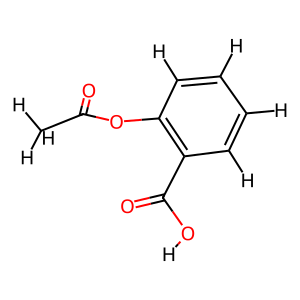

In [9]:
coord_idx = 6
rd_mol = Chem.RWMol()
mol_num = data_charges.shape[0]
rd_conf = Chem.Conformer(int(mol_num))
for i in range(mol_num):
    rd_atom = Chem.Atom(int(data_charges[i]))
    rd_mol.AddAtom(rd_atom)
    rd_coords = Geometry.Point3D(float(data_coords[coord_idx][i][0]), 
                                 float(data_coords[coord_idx][i][1]), 
                                 float(data_coords[coord_idx][i][2]))
    rd_conf.SetAtomPosition(i, rd_coords)
rd_mol.AddConformer(rd_conf)
mol = rd_mol.GetMol()
conn_mol = Chem.Mol(mol)
rdDetermineBonds.DetermineBonds(conn_mol,charge=0)
Draw.MolToImage(conn_mol)

In [10]:
print(conn_mol.GetNumAtoms(),conn_mol.GetNumBonds())

21 21


In [11]:
statis = Chem.MolToMolBlock(conn_mol)
bonds = re.findall(r'([1-9][0-9^.]*)\s+([1-9][0-9^.]*)\s+([1-9^.])\s+0\s+', statis)#键信息
data_bonds = np.array(bonds).astype(int)
print(data_bonds)

[[ 1  3  2]
 [ 1  6  1]
 [ 1 15  1]
 [ 2  4  2]
 [ 2  7  1]
 [ 2 16  1]
 [ 3  4  1]
 [ 3 17  1]
 [ 4 18  1]
 [ 5 12  1]
 [ 5 19  1]
 [ 5 20  1]
 [ 5 21  1]
 [ 6  7  2]
 [ 6 11  1]
 [ 7 13  1]
 [ 8 11  2]
 [ 9 12  2]
 [10 11  1]
 [10 14  1]
 [12 13  1]]


In [12]:
save_file = data_file.split('.')
save_file = '../test/' + save_file[0] +'_new.' + save_file[1]

np.savez(data_file, nuclear_charges=data_charges, 
         coords=data_coords, bonds=data_bonds)